### Da Si - 445057
###### University of Chicago - FInancial Mathematics
###### FINM 33150 - Regression Analysis and Quantitative Trading Strategies
###### Homework2: Simple Spread Trading

Below is my code for this homework assignment. I have designed it so that the whole trading strategy is in a function called 'spreadTrading'. This is because of the analysis part; to do analysis, I vary the parameters by looping through the spreadTrading function. I have used data from the EOD Quandl. The ETFs I am analyzing are RTH and XRT

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import Quandl
import functools
import seaborn as sns
import ggplot as gg
from datetime import timedelta

# change font size of the x, y axis
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

In [3]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities, start, end):
    qdata = Quandl.get(list(my_securities), returns="pandas", trim_start=start, trim_end=end, authtoken="z2yoF1Mryjst1k4hSN7p")
    return qdata

In [4]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('.')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

## Note : 
In this function I set **g** and **j** to be some number that is **G** and **J** standard deviation from mean of spread across the whole time period. Although it seems to have lookahead bias, it is really not a big issue in our case since this is basically same as setting g and j to be any two values and test them on different levels (since we can change G and J to any value). The real intuition of setting g and j this way is that in real treading and backtesting we can change the calculation of g and j based on the distribution of the past n days of the spread. And because the time range in this dataset is small so I decided not to set window for calculation of past mean and standard deviation of spread.

In [5]:
def spreadTrading(M,J,G,s,data):
    """
    M ~ timeframe for return calculation
    N ~ number of standard deviation that g and j are around the mean of spread
    s ~ stop loss threshold
    data ~ DataFrame containing the daily close price for ETF X and Y, and the volumne for X
    
    The function returns 6 pandas Series: 4 are signals of buy/sell/stop loss/end of month, 
    they are used later for plotting purposes. The rest two are Series of daily cash and position value.
    In this way we can get the total portfolio level and calculate profit.
    """
    # calculate log return and spread
    data["X_ret"] = np.log(data["X:Adj_Close"]) - np.log(data["X:Adj_Close"].shift(M))
    data["Y_ret"] = np.log(data["Y:Adj_Close"]) - np.log(data["Y:Adj_Close"].shift(M))
    data["spread"] = data["X_ret"] - data["Y_ret"]

    mean = data.spread.mean()
    std = data.spread.std()
    g = mean + G * std
    j = mean + J * std
    # get the first date of the following month
    d = data.index[M]
    startDate = pd.date_range(start = d, periods = 1, freq = 'BMS') # get first business day of portfolio
    endOfMonths =  pd.date_range(start, end, freq = 'BM') # end of months (business day, maybe holiday)
    diff = pd.Series(data.index.month).diff()
    mask = (diff != 0)
    startOfMonth = data.index[mask]
    startDate = startOfMonth[startOfMonth.month == startDate[0].month][0] # make sure startDate is not a holiday
    endOfMonth = data.index[mask.shift(-1).fillna(False)] # this way excludes any possible holidays
    temp = endOfMonth.tolist()
    temp.append(endOfMonths[-1])
    endOfMonth = pd.DatetimeIndex(temp)
    # time range for actual trading (1 day ahead for recording purposes)
    timeFrame = data.index[data.index >= (startDate- timedelta(days = 1))] 
    temp = timeFrame.tolist()
    temp = [startDate- timedelta(days = 1)] + temp
    timeFrame = pd.DatetimeIndex(temp)
    temp = None
    # set variables for trading simulation
    hold = 0
    X_position = 0
    Y_position = 0
    tradedCash = 0
    positionVal = pd.Series(np.zeros(len(timeFrame)), index = timeFrame) # position value
    Cash = pd.Series(np.zeros(len(timeFrame)), index = timeFrame) # cash of portfolio
    # set initial cash
    Cash[0] = K
    # record buy/sell/end of month signals for plotting
    SignalL = pd.Series(np.zeros(len(timeFrame)), index = timeFrame, dtype=bool)
    SignalS = pd.Series(np.zeros(len(timeFrame)), index = timeFrame, dtype=bool)
    SignalSL = pd.Series(np.zeros(len(timeFrame)), index = timeFrame, dtype=bool)
    SignalEOM = pd.Series(np.zeros(len(timeFrame)), index = timeFrame, dtype=bool)
    """
    begin trading simulation, the order of if statement is to check sell signal first, then buy signal and stop loss signal
    in the end. This order allows same-day re-entry after selling and prevent re-entry when stop loss is triggered
    """
    for day in timeFrame[1:]:
        yesterday = timeFrame[timeFrame.get_loc(day)-1]
        # cumulate cash from yesterday
        Cash[day] = Cash[yesterday] 
        spread = data.loc[day,"spread"] # spread of the day
        # value of current position (if there is one)
        positionVal[day] = data.loc[day,"X:Adj_Close"] * X_position + data.loc[day,"Y:Adj_Close"] * Y_position

        # check whether to sell
        if (hold == 1 and spread < j) or (hold == -1 and spread > -j) or (hold != 0 and (day in endOfMonth)):   
            # record signal
            # notice if entering from positive g then exit when cross j from above, 
            # if entering from negative g then exit when cross -j from below
            SignalS[day] = (hold == 1 and spread < j) or (hold == -1 and spread > -j)
            SignalEOM[day] = (day in endOfMonth)
            # adjust cash value after flatting position
            Cash[day] = Cash[day] + positionVal[day]
            # reset position to zero
            X_position = 0
            Y_position = 0
            positionVal[day] = 0
            tradedCash = 0
            hold = 0
            
        # check whether to buy
        if (hold == 0) and (abs(spread) > g) and (day not in endOfMonth):
            # record signal
            SignalL[day] =(abs(spread) > g)
            # amount of position for X and Y
            X_position = - np.sign(spread) * int (data.loc[day,"size"] / data.loc[day,"X:Adj_Close"])
            Y_position = + np.sign(spread) * int (data.loc[day,"size"] / data.loc[day,"Y:Adj_Close"])
            # gross traded cash
            tradedCash = data.loc[day,"X:Adj_Close"] * abs(X_position) + data.loc[day,"Y:Adj_Close"] * abs(Y_position)
            # real value of combined long/short position
            positionVal[day] = data.loc[day,"X:Adj_Close"] * X_position + data.loc[day,"Y:Adj_Close"] * Y_position
            # cash adjustment after creating portfolio
            Cash[day] = Cash[day] - positionVal[day]
            hold = np.sign(spread)
        
        # check stop loss
        if (hold !=0) and (positionVal[day] / tradedCash < -s):
            SignalSL[day] = (positionVal[day] / tradedCash < -s)
            Cash[day] = Cash[day] + positionVal[day]
            # reset position to zero
            X_position = 0
            Y_position = 0
            positionVal[day] = 0
            tradedCash = 0
            hold = 0
    d = {'spread':data.spread[timeFrame],
         'SignalL':SignalL,
         'SignalS':SignalS,
         'SignalSL':SignalSL,
         'SignalEOM':SignalEOM,
         'Cash':Cash,
         'positionVal':positionVal
         }
    result = pd.DataFrame(d)
    return result

Now that we have finished building the strategy function, let us run a single test on our ETFs and do some plotting to see how the strategy performs

In [6]:
def plotResult(data):
    # plot the signals along the spread and along the cumulative profit
    mean = data.spread.mean()
    std = data.spread.std()
    g = mean + G * std
    j = mean + J * std
    fig = plt.figure(figsize=(20,12))
    plt.plot(data["spread"], label = 'Spread')
    plt.hold(True)
    # plot signal
    plt.scatter(y = data.loc[data.index[data.SignalL],'spread'], x = data.index[data.SignalL], label = 'Entry', c = 'g', s = 50)
    plt.scatter(y = data.loc[data.index[data.SignalS],'spread'], x = data.index[data.SignalS], label = 'Exit', c = 'r', s = 50)
    plt.scatter(y = data.loc[data.index[data.SignalSL],'spread'], x = data.index[data.SignalSL], label = 'Stop Loss', c = 'k', s = 50)
    plt.scatter(y = data.loc[data.index[data.SignalEOM],'spread'], x = data.index[data.SignalEOM], label = 'EOM', c = 'c', s = 50)
    # plot bound
    plt.plot((data.index[0], data.index[-1]), (g, g),'m-',label = 'g')
    plt.plot((data.index[0], data.index[-1]), (j, j),'b-',label = 'j')
    plt.plot((data.index[0], data.index[-1]), (-g, -g),'m-')
    plt.plot((data.index[0], data.index[-1]), (-j, -j),'b-')
    plt.legend(loc = 2, prop={'size':15},numpoints = 1)
    # change axis range
    axes = plt.gca()
    axes.set_xlim([data.index[0], data.index[-1]])

    fig2 = plt.figure(figsize=(20,12))
    Profit = data.Cash + data.positionVal - K
    plt.plot(Profit, label = 'Profit')
    plt.hold(True)
    plt.scatter(y = Profit.loc[data.index[data.SignalL]], x = data.index[data.SignalL], label = 'Entry', c = 'g', s = 50)
    plt.scatter(y = Profit.loc[data.index[data.SignalS]], x = data.index[data.SignalS], label = 'Exit', c = 'r', s = 50)
    plt.scatter(y = Profit.loc[data.index[data.SignalSL]], x = data.index[data.SignalSL], label = 'Stop Loss', c = 'k', s = 50)
    plt.scatter(y = Profit.loc[data.index[data.SignalEOM]], x = data.index[data.SignalEOM], label = 'EOM', c = 'c', s = 50)
    plt.legend(loc = 2, prop={'size':20},numpoints = 1)
    axes = plt.gca()
    axes.set_xlim([data.index[0], data.index[-1]])

In [7]:
# set ETF tickers, start end date
X = 'RTH'
Y = 'XRT'
start = "2013-12-02"
end = "2015-12-31"
# fetch data
raw_data = fetch_quandl(("EOD/" + X , "EOD/" + Y), start, end)
renamed_data = clean_quandl_columns(raw_data)
data = renamed_data[[X + ":Adj_Close", X + ":Adj_Volume", Y +":Adj_Close"]]
data.columns = ["X:Adj_Close", "X:Adj_Volume", "Y:Adj_Close"]
renamed_data = None # delete old dataset to save space
# rolling 15 day dollar volume
Nt = data["X:Adj_Close"]* data["X:Adj_Volume"].rolling(window = 15).median()
#inial capital
K = Nt.max()*2 
#trade size
data["size"] = Nt / 100 

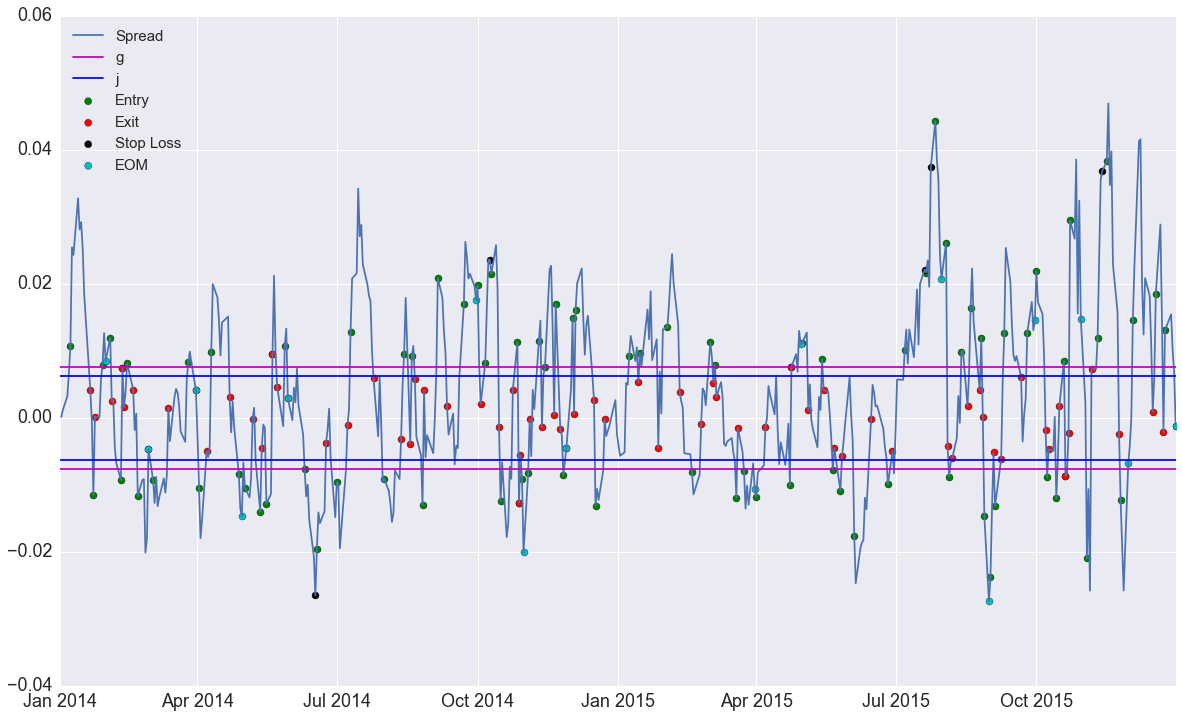

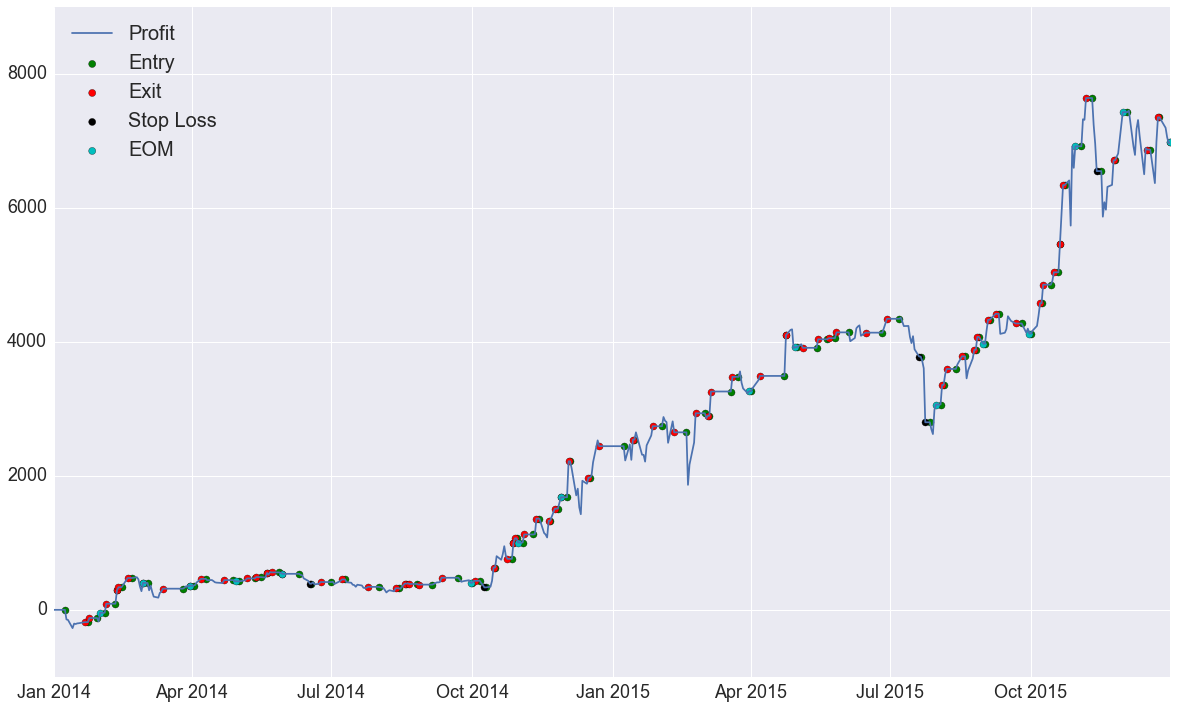

In [19]:
M = 7
J = 0.2
G = 0.3
s = 0.011
plotResult(spreadTrading(M,J,G,s,data))

Above you can see the signals of getting in and out of position along with the level of spread and total profit. 

### Analysis
Now it is time to do some analysis on the strategy. Specifically, we are looking at how change of M, J, width = G-J and s are affecting the performance of our strategy based on the value of profilt. 

It is very difficult to run the optimization for all parameters at the same time. So I decided to optimize one at each time, setting the other variables at several part of reasonable values.

## M
First, I want to see how change of M affects the portfolio. I create a function that plots the performance of portfolio as M changes from 2 to 30 days, I test the trend use 4 different J and G level.

In [9]:
def M_test(J,G): 
    s = 0.009
    M_range = np.arange(2,60,2)
    M_test = pd.DataFrame(index = M_range, columns = ['Profit'])

    for M in M_range:
        result = spreadTrading(M,J,G,s,data)
        Profit = result.Cash + result.positionVal - K
        M_test.loc[M,'Profit'] = Profit[-1]
    plt.plot(M_test)
    plt.title('Profit When Varying M '+ '(J = '+str(J)+', G = '+str(G)+')', fontsize = 20)
    plt.ylabel('Total Profit (dollars)',fontsize = 15)
    plt.xlabel('M (days)',fontsize = 15)
    plt.grid(True)

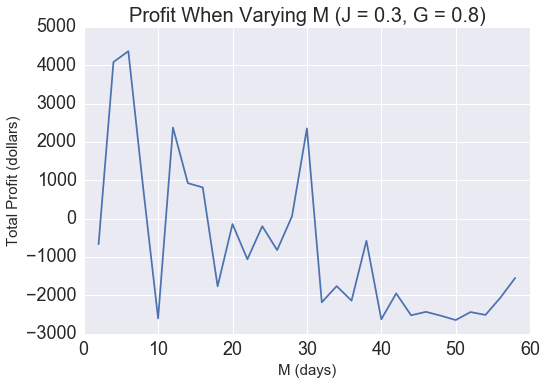

In [10]:
M_test(0.3,0.8)

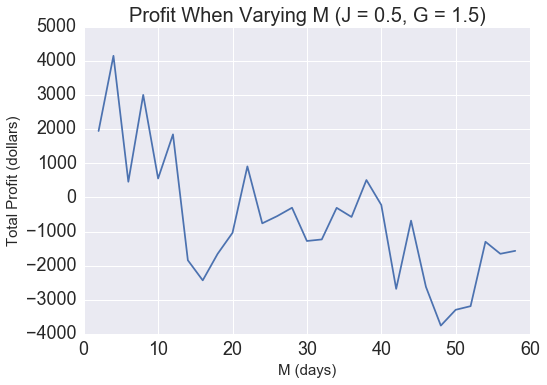

In [11]:
M_test(0.5,1.5)

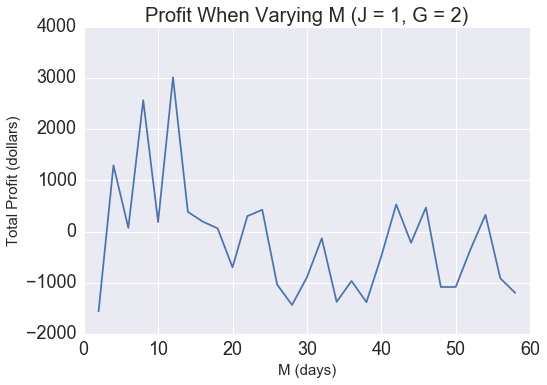

In [12]:
M_test(1,2)

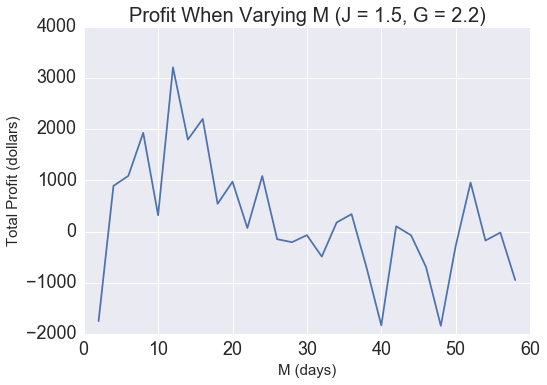

In [13]:
M_test(1.5,2.2)

There are some similarities among the four graphs. Portfolio returns better when M is between 5 to 15 and sometimes above 30, depends where G and J is set. Lower entry and exit levels work better with smaller M value and higher levels work better with larger M value.

## J (which determines j)
In testing J I did something similar as previous one, which is testing the performance of portfolio with J varies from 0.01 to 2.2, and at the same time use different good M values that we get from previous test. I also define width = G - J and set it to be several value.

In [14]:
def J_test(M,width): 
    s = 0.009
    J_range = np.arange(0.01,2.2,0.1)
    J_test = pd.DataFrame(index = J_range, columns = ['Profit'])

    for J in J_range:
        result = spreadTrading(M,J,J+width,s,data)
        Profit = result.Cash + result.positionVal - K
        J_test.loc[J,'Profit'] = Profit[-1]
    plt.plot(J_test)
    plt.title('Profit When Varying J '+ '(M = '+str(M)+', width = '+str(width)+')', fontsize = 20)
    plt.ylabel('Total Profit (dollars)',fontsize = 15)
    plt.xlabel('J (stds)',fontsize = 15)
    plt.grid(True)

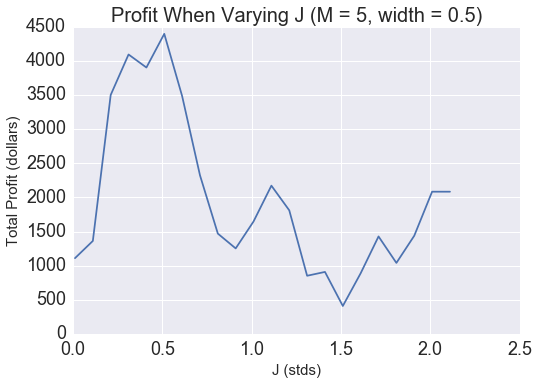

In [15]:
J_test(5,0.5)

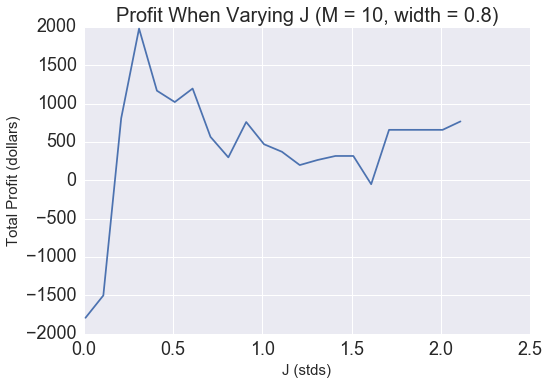

In [16]:
J_test(10,0.8)

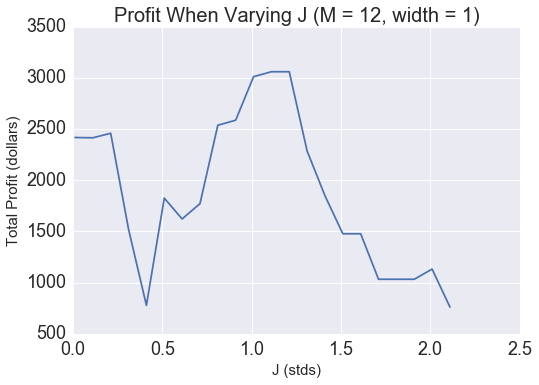

In [17]:
J_test(12,1)

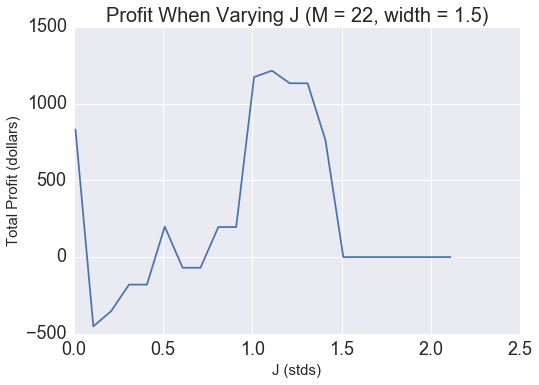

In [18]:
J_test(22,1.5)

From the four graphs above it is clear that the best J gets high as M gets large. When M is small, it is better strategy to enter and exit at lower level and make frequent trade. While when M gets larger, the spread gets less volatile so it is good to enter and exit trade with larger j and g value to capture the mean reversion.

## width (G - J)
Next let us test how the size of difference between entry and exit level affects the performance of the our strategy.

In [19]:
def w_test(M,J): 
    s = 0.009
    w_range = np.arange(0.01,2.2,0.1)
    w_test = pd.DataFrame(index = w_range, columns = ['Profit'])

    for w in w_range:
        result = spreadTrading(M,J,J+w,s,data)
        Profit = result.Cash + result.positionVal - K
        w_test.loc[w,'Profit'] = Profit[-1]
    plt.plot(w_test)
    plt.title('Profit When Varying J '+ '(M = '+str(M)+', J = '+str(J)+')', fontsize = 20)
    plt.ylabel('Total Profit (dollars)',fontsize = 15)
    plt.xlabel('width (stds)',fontsize = 15)
    plt.grid(True)

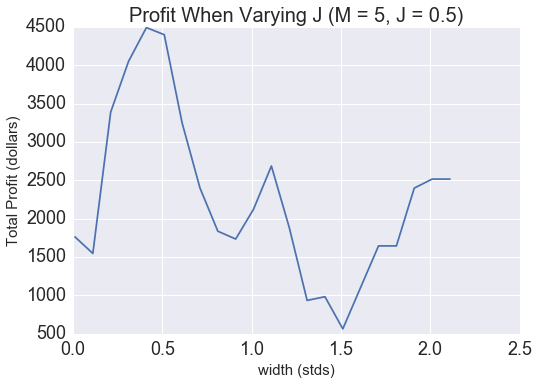

In [20]:
w_test(5, 0.5)

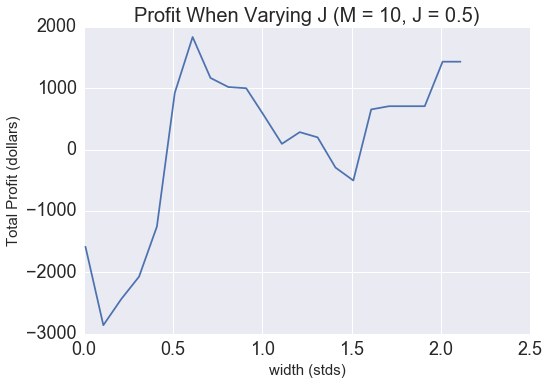

In [21]:
w_test(10, 0.5)

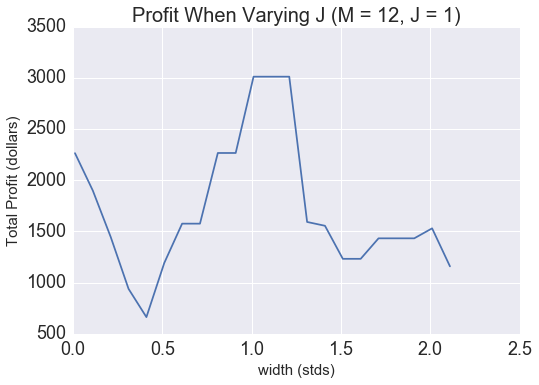

In [22]:
w_test(12, 1)

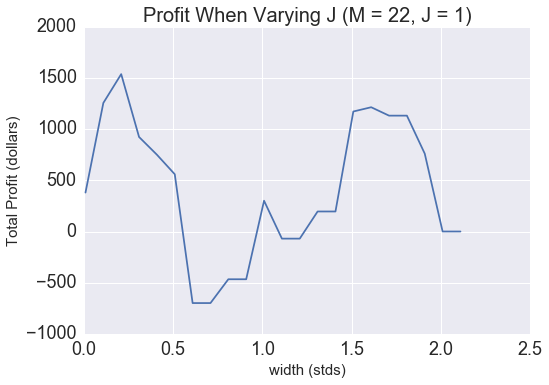

In [23]:
w_test(22, 1)

Consistent with what we just found earlier, the best width gets larger as M gets large. This also makes sense because when the scale gets large, there is less small frequent trade available and in order to capture profit in fewer larger trade, the spread also needs to get large. One interesting finding is that in the last graph the smaller width works well too. After plotting each trade I found that when M gets large and J is large, there are much less trades and the overall PnL is heavily dependent on 1 or 2 trades. So as the width change some trades gets eliminated and the PnL change sharply. 

## s (stop loss)
In the end we test how change of the the stop loss level affects the performance. I used best pairs of M, J, G we have found from previous test

In [24]:
def s_test(M,J,width):
    s_range = np.arange(0,0.02,0.001)
    s_test = pd.DataFrame(index = s_range, columns = ['Profit'])

    for s in s_range:
        result = spreadTrading(M,J,J+width,s,data)
        Profit = result.Cash + result.positionVal - K
        s_test.loc[s,'Profit'] = Profit[-1]
    plt.plot(s_test)
    plt.title('Profit When Varying s '+ '(M = '+str(M)+', J = ' + str(J) + ', width = '+str(width)+ ')', fontsize = 20)
    plt.ylabel('Total Profit (dollars)',fontsize = 15)
    plt.xlabel('s (stop loss)',fontsize = 15)
    plt.grid(True)

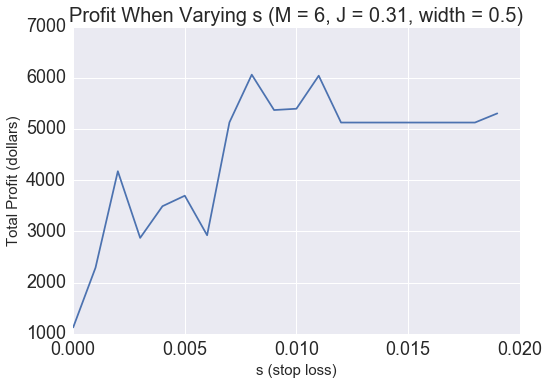

In [25]:
s_test(6,0.31,0.5)

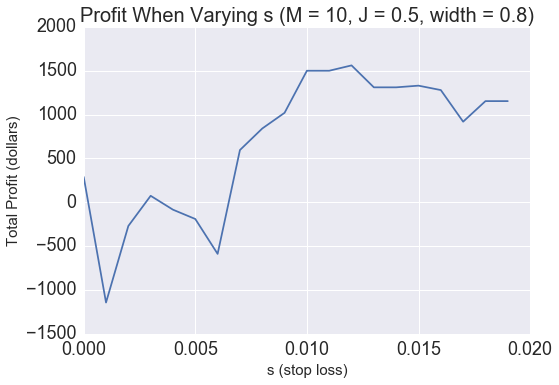

In [26]:
s_test(10,0.5,0.8)

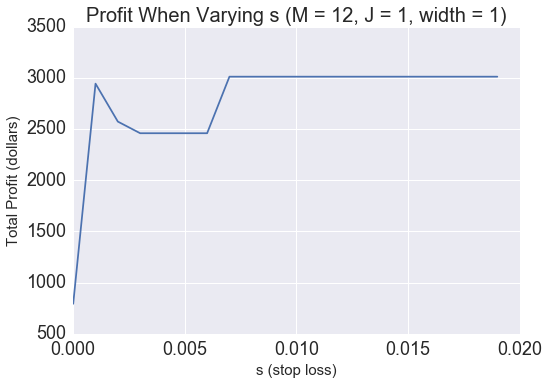

In [27]:
s_test(12,1,1)

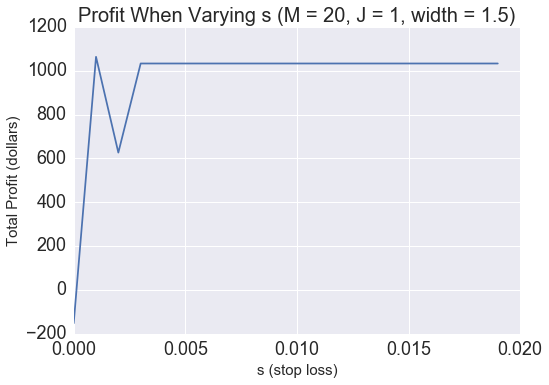

In [28]:
s_test(20,1,1.5)

As we can see from above, generally the profit increases and stables as stop loss increases. A good level to set s would be from 0.008 to 0.012. As M gets larger, less stop losses are triggerd so there is less difference of profits when change the value of s. Notice the profit gets a little smaller as s gets too large since some trades may be eliminated too early before they become profitable.

Overall I found the strategy tend to be profitable when M is  around 5 and 15. The good option of J and the width of band (G - J) gets larger as M gets larger. And s is good around 0,01.

## 2-D test (test G and J at same time)

In [8]:
# This is a double loop that test J and width at same time for specific M, it returns a table of profits
def double_test(M):
    s = 0.011
    J_range = np.arange(0.0,1.6,0.1)
    w_range = np.arange(0.0,1.1,0.1)
    test = pd.DataFrame(index = J_range, columns = w_range,dtype = float)
    for J in J_range:
        for w in w_range:
            result = spreadTrading(M,J,J+w,s,data)
            Profit = result.Cash + result.positionVal - K
            test.loc[J,w] = Profit[-1]
    return test

In [9]:
test = double_test(7)

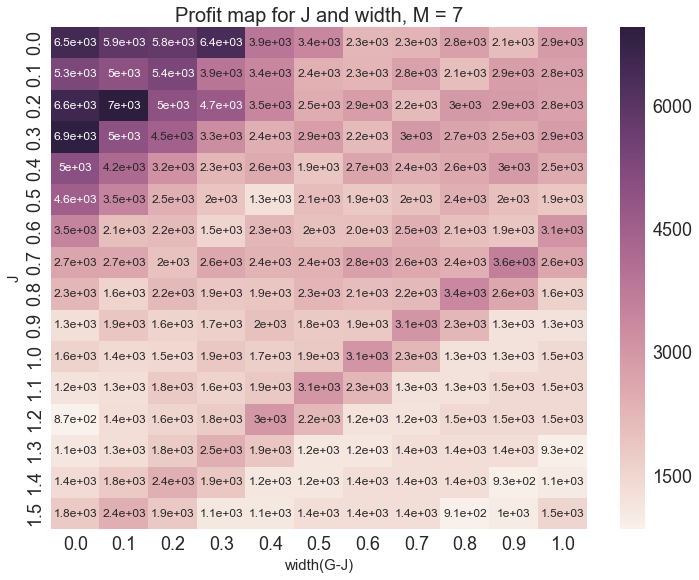

In [35]:
# The vertical axis is J, horizontal axis is width = G - J
test = test.round(0)
plt.figure(figsize=(12, 9))
ax = sns.heatmap(test, annot = True)
sns.axlabel('width(G-J)','J',fontsize = 15)
sns.plt.title('Profit map for J and width, M = 7', fontsize = 20)

## Results for 2-D test
After running some 2-D test on both G and J for several M window and plot the heat map, I found that the profit are similar when J + width = J + (G-J) = G when G is some fixed value. So sometimes G, which is the entering barrier, is the parameter that matters the most. And when window(M) gets large, it is sometimes optimal to set G close to 0 to encourage more trades when crossing 0 line, since a trade that crosses the zero line the next day is guarenteed to make money.